In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import torch.nn as nn
import torch.nn.functional as F
dropout_value = 0.1
group = 1

class Net(nn.Module):
    # This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
       # input 32/1/1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2
        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2
        self.conv6 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 16),
        ) # output_size = 16/18/2
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0),
        ) # output_size = 16/18/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/20/4
        self.conv8 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 8/28/4
        self.conv9 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/36/4
        self.conv10 = nn.Sequential(
            nn.Conv2d(64, 16, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(group, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 8/44/4
       # self.avgpool = nn.AvgPool2d(5)
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1
        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0),
            # nn.nn.GroupNorm(group, 16),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        #self.fc1 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool1(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.gap(x)
        x = self.conv11(x)
        x = x.view(x.size(0), -1)
      #  x = self.fc1(x)
        return F.log_softmax(x, dim=1)


In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,320
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             272
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,320
             ReLU-12           [-1, 16, 16, 16]               0
        GroupNorm-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

In [5]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 40754893.76it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
batch_size = 256

kwargs = {'batch_size': batch_size, 'shuffle': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

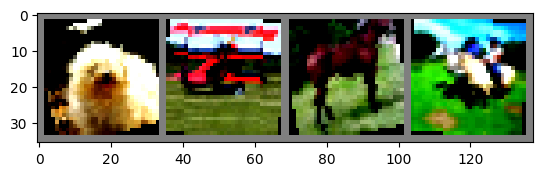

dog   plane horse horse


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
from tqdm import tqdm

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {"images": [], "ground_truths": [], "predicted_vals": []}


def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(
            desc=f"Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    return train_acc, train_losses


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(
                output, target, reduction="sum"
            ).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100.0 * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    return test_acc, test_losses

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_losses = train(model, device, train_loader, optimizer, criterion)
  test_acc, test_losses = test(model, device, test_loader, criterion)
  scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.8224 Batch_id=195 Accuracy=27.17: 100%|██████████| 196/196 [00:51<00:00,  3.80it/s]


Test set: Average loss: 1.7794, Accuracy: 3379/10000 (33.79%)

Epoch 2


Train: Loss=1.4758 Batch_id=195 Accuracy=37.08: 100%|██████████| 196/196 [00:43<00:00,  4.51it/s]


Test set: Average loss: 1.5563, Accuracy: 4199/10000 (41.99%)

Epoch 3


Train: Loss=1.4314 Batch_id=195 Accuracy=43.40: 100%|██████████| 196/196 [00:41<00:00,  4.72it/s]


Test set: Average loss: 1.4558, Accuracy: 4487/10000 (44.87%)

Epoch 4


Train: Loss=1.0806 Batch_id=195 Accuracy=48.07: 100%|██████████| 196/196 [00:42<00:00,  4.59it/s]


Test set: Average loss: 1.3181, Accuracy: 5179/10000 (51.79%)

Epoch 5


Train: Loss=1.4600 Batch_id=195 Accuracy=51.78: 100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Test set: Average loss: 1.2391, Accuracy: 5547/10000 (55.47%)

Epoch 6


Train: Loss=1.1901 Batch_id=195 Accuracy=55.60: 100%|██████████| 196/196 [00:41<00:00,  4.74it/s]


Test set: Average loss: 1.1522, Accuracy: 5798/10000 (57.98%)

Epoch 7


Train: Loss=1.2156 Batch_id=195 Accuracy=57.60: 100%|██████████| 196/196 [00:41<00:00,  4.71it/s]


Test set: Average loss: 1.0631, Accuracy: 6174/10000 (61.74%)

Epoch 8


Train: Loss=1.0550 Batch_id=195 Accuracy=59.45: 100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Test set: Average loss: 0.9924, Accuracy: 6423/10000 (64.23%)

Epoch 9


Train: Loss=0.9265 Batch_id=195 Accuracy=60.89: 100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Test set: Average loss: 1.0481, Accuracy: 6205/10000 (62.05%)

Epoch 10


Train: Loss=1.0717 Batch_id=195 Accuracy=62.03: 100%|██████████| 196/196 [00:41<00:00,  4.77it/s]


Test set: Average loss: 0.9399, Accuracy: 6606/10000 (66.06%)

Epoch 11


Train: Loss=1.0241 Batch_id=195 Accuracy=65.76: 100%|██████████| 196/196 [00:41<00:00,  4.70it/s]


Test set: Average loss: 0.8761, Accuracy: 6855/10000 (68.55%)

Epoch 12


Train: Loss=0.9014 Batch_id=195 Accuracy=66.25: 100%|██████████| 196/196 [00:42<00:00,  4.66it/s]


Test set: Average loss: 0.8814, Accuracy: 6871/10000 (68.71%)

Epoch 13


Train: Loss=0.8177 Batch_id=195 Accuracy=66.75: 100%|██████████| 196/196 [00:41<00:00,  4.74it/s]


Test set: Average loss: 0.8625, Accuracy: 6958/10000 (69.58%)

Epoch 14


Train: Loss=1.0409 Batch_id=195 Accuracy=66.90: 100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Test set: Average loss: 0.8615, Accuracy: 6945/10000 (69.45%)

Epoch 15


Train: Loss=1.0449 Batch_id=195 Accuracy=67.09: 100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Test set: Average loss: 0.8767, Accuracy: 6910/10000 (69.10%)

Epoch 16


Train: Loss=0.8926 Batch_id=195 Accuracy=67.21: 100%|██████████| 196/196 [00:41<00:00,  4.73it/s]


Test set: Average loss: 0.8478, Accuracy: 6981/10000 (69.81%)

Epoch 17


Train: Loss=0.9443 Batch_id=195 Accuracy=67.35: 100%|██████████| 196/196 [00:41<00:00,  4.74it/s]


Test set: Average loss: 0.8430, Accuracy: 6981/10000 (69.81%)

Epoch 18


Train: Loss=0.8509 Batch_id=195 Accuracy=67.67: 100%|██████████| 196/196 [00:41<00:00,  4.68it/s]


Test set: Average loss: 0.8362, Accuracy: 7014/10000 (70.14%)

Epoch 19


Train: Loss=0.8371 Batch_id=195 Accuracy=67.76: 100%|██████████| 196/196 [00:41<00:00,  4.69it/s]


Test set: Average loss: 0.8599, Accuracy: 6925/10000 (69.25%)

Epoch 20


Train: Loss=0.9225 Batch_id=195 Accuracy=67.90: 100%|██████████| 196/196 [00:41<00:00,  4.73it/s]


Test set: Average loss: 0.8379, Accuracy: 7008/10000 (70.08%)



In [10]:
# define a function to unnormalize image data
def unnormalize(img):
    channel_means = (0.4914, 0.4822, 0.4471)
    channel_stdevs = (0.2469, 0.2433, 0.2615)
    img = img.numpy().astype(dtype=np.float32)

    for i in range(img.shape[0]):
         img[i] = (img[i]*channel_stdevs[i])+channel_means[i]

    return np.transpose(img, (1,2,0))


# define a function for misclassified images
def plot_misclassified_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(npimg, cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()

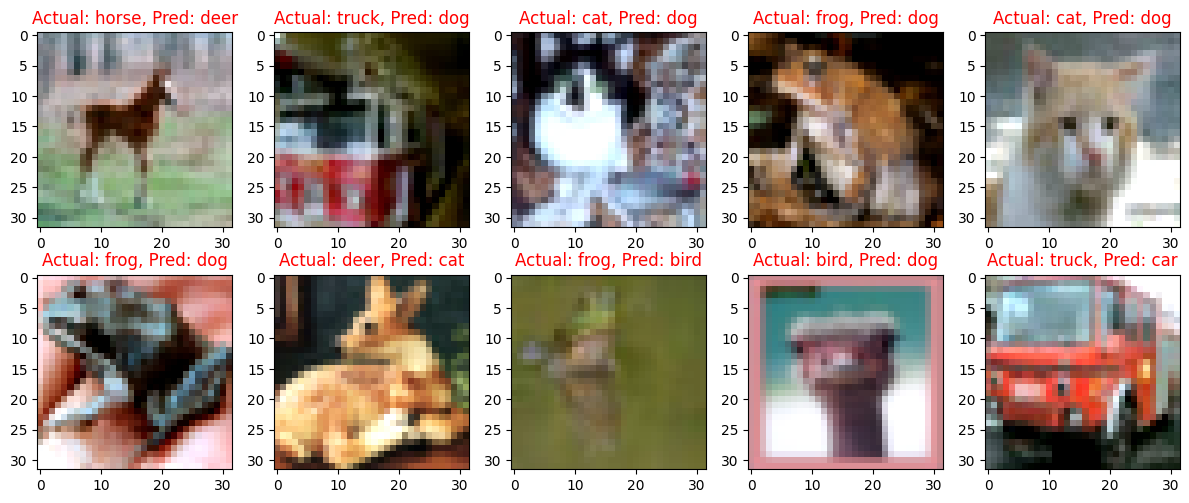

In [11]:
plot_misclassified_images(model, test_loader, classes, device)